In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

In [3]:
from feat_metrics import calculate_n_day_return, calculate_sma, calculate_momentum
from feat_metrics import calculate_volatility, calculate_ema, calculate_capm
from process_modules import TrainModel
from process_modules.load_data import LoadData
from move_data import load_models

# Brazilian stock price prediction

## Table of Contents

1. [Project Definition](#Project-Definition)<br>
2. [Analysis](#Analysis)<br>
3. [Methodology](#Methodology)<br>
4. [Results](#Results)<br>
5. [Conclusion](#Conclusion)<br>

## <a class="anchor" id="Project-Definition">Part I : Project Definition</a>

Predict stocks price or having some type of advantage in market decision is a subject of great interest. However, [Efficient Markets Hypothesis](https://www.investopedia.com/terms/e/efficientmarkethypothesis.asp) says that it is not possible to beat the market because its behaviour is completely random. But a lot of hedge funds have had high gains historically. Can we predict stock prices?

### Problem Statement

For this project, I was interested to study more about stock market and time series. Moreover, I was eager to know which kind of features I will use and check how well I will predict stocks in a first approach. So the challenge is to build a stock price predictor that takes daily trading data over a certain date range as input, and outputs projected estimates for given query dates. The predicted target is adjusted close stock price, it is close price adjusted historically after splits, dividends and other events. These models are built for different stocks and estimate prices for several future days.

The project description is available from Udacity at this [link](https://docs.google.com/document/d/1ycGeb1QYKATG6jvz74SAMqxrlek9Ed4RYrzWNhWS-0Q/pub). 


All data are from [Yahoo Finance](https://finance.yahoo.com/) and extracted by [yahooquery](https://pypi.org/project/yahooquery/) API. 

There are two broad categories of approaches used for choose stocks to buy or sell. They are fundamental analysis and technical analysis.
- Fundamental analysis: Look for aspects of a company to try estimate its real value. If the price of this stock is lower than its value buy it and if it is higher than its value sell it.

- Technical analysis: Just use price and volume to discovery patterns and trends to buy or sell a stock.


For this project, it will follow Technical approach. It will be created some features based in theorical and practical market knowledge
only using past adjusted close price of the specific stock and a market index. The expected solution is not a high performance model, because this problem is really complex.
But understading more about this topic and finding a starting point to tackle this subject are the expected solution.

### Metrics

This problem will be see as a regression problem, so the main metric calculated to evalute models is [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) (mean absolute error).
For each trained model, the train data set will be splited in train and test set. The test set will be composed by 25% of the newest data and train set with the rest of data. 

Some stock models will be compared for 4 different target predictions days with a baseground date:
- Next workday of baseground date
- Next week of baseground date (approximated by next 5 workdays)
- Next 2 weeks of baseground date (approximated by next 10 workdays)
- Next month of base ground date (approximated by next 22 workdays)

After calculated MAE for test set in this train and test approach, it will be used all training period to refit model and deploy this final model. Moreover, the fitted models can use other baseground date different from last day of train set. However, for distant days from train period the performance probably will decrease. 

Finally, to get some insights for future works, it will be visually analysed the shape of predicted price curve aganist real price curve.

## <a class="anchor" id="Analysis">Part 2 : Analysis</a>

### Data Exploration and Visualization

In [4]:
# Function to read from yahooquery API and save it in db
load_data = LoadData('data/Stocks.db')
load_data.load()

In [5]:
# Read data from db in a dataframe
engine = create_engine('sqlite:///data/Stocks.db')
stocks_df = pd.read_sql_table('stocks', engine)

In [6]:
stocks_df.head(3)

,symbol,date,close,low,open,high,volume,adjclose,dividends,splits
0,^BVSP,1993-04-27,24.500000,24.500000,24.799999,25.400000,0.0,24.500000,0.0,0.0
1,^BVSP,1993-04-28,24.299999,23.700001,24.500000,24.600000,0.0,24.299999,0.0,0.0
2,^BVSP,1993-04-29,23.700001,23.700001,24.299999,24.799999,0.0,23.700001,0.0,0.0


Only some tickers were read from API. If this number would be increased, processing time was increased too with no gain in project development.

In [7]:
# Stocks read from API
stocks_df.symbol.unique().tolist()

['^BVSP',
 'ITSA4',
 'MGLU3',
 'VVAR3',
 'WEGE3',
 'MDIA3',
 'LREN3',
 'ITUB3',
 'EGIE3']

^BVSP is a brazilian stock index of most valued companies. It will be a proxy for market oscilation, similiar of SP500 in EUA.

In [8]:
stocks_df.isnull().sum()

symbol       0
date         0
close        0
low          0
open         0
high         0
volume       0
adjclose     0
dividends    0
splits       0
dtype: int64

No nulls found

In [9]:
stocks_df.dtypes

symbol               object
date         datetime64[ns]
close               float64
low                 float64
open                float64
high                float64
volume              float64
adjclose            float64
dividends           float64
splits              float64
dtype: object

Column types are ok

#### Columns description:

- **symbol**: Ticker of specific stock
- **date**: Reference date
- **close**: Close stock price in reference date
- **high**: The highest stock price achived in reference date
- **open**: Open stock price in reference date
- **low**: The lowest stock price achived in reference date
- **volume**: Volume of transactions of specific ticker in reference date 
- **adjclose**: Close stock price in reference date adjusted historically when events happened such as dividends, splits and price modificators.
- **dividends**: Divideds payed per unit in reference date
- **splits**: Modificator ratio in number of papers in reference date. Ex.: 10 units became 11, if splits were 1.1.

In [10]:
min_date = stocks_df.date.min().date()
max_date = stocks_df.date.max().date()

print(f'The minimun date in dataset is: {min_date}')
print(f'And this data is read every run time from API, so maximun date is {max_date}.')

The minimun date in dataset is: 1993-04-27
And this data is read every run time from API, so maximun date is 2021-02-12.


In [11]:
# An auxiliar function to make some plots
def plot_series(df, symbol, col_date, col_value, y_label):
    ''' Plot a time series.
    
    params:
    df (dataframe): Input dataframe
    symbol (string): Specific ticker for a stock in df
    col_date (string): Column name with date value
    col_value (string): Columns name with numeric value
    y_label (string): Label to y axis.
    '''
    data = df.copy()
    data.set_index(col_date, inplace=True)
    data = data[data.symbol == symbol][col_value]
    ax = data.plot()
    ax.set_title(symbol + ' '+ col_value)
    ax.set_ylabel(y_label)

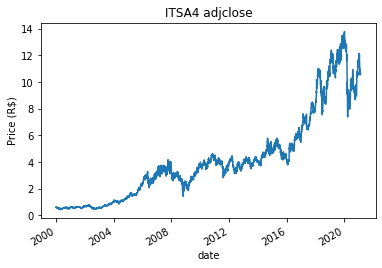

In [12]:
plot_series(stocks_df, 'ITSA4', 'date', 'adjclose', 'Price (R$)')

For ITSA4, the price range arrives R$ 14 (Brazilian currency) and we have data since 2000.

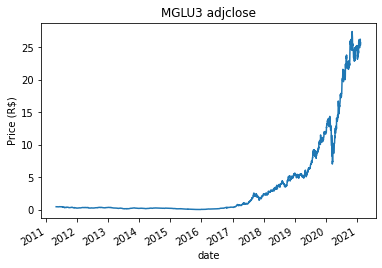

In [13]:
plot_series(stocks_df, 'MGLU3', 'date', 'adjclose', 'Price (R$)')

For MGLU3, the price range arrives R$ 27 and we have data since 2011.

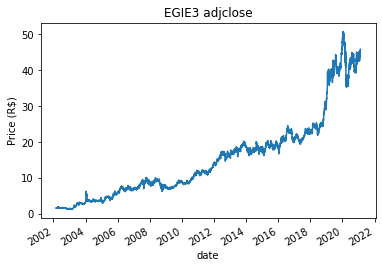

In [14]:
plot_series(stocks_df, 'EGIE3', 'date', 'adjclose', 'Price (R$)')

For EGIE3, the price range arrives R$ 51 and we have data since 2002.

Both stocks have different behaviors, price ranges and historic data over the time. However, they were a good invest choice up to now due to their exponential shape. 

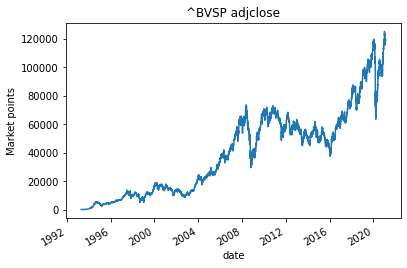

In [15]:
plot_series(stocks_df, '^BVSP', 'date', 'adjclose', 'Market points')

Market index increased a lot over the time too.

For this project only symbol, date and adjclose were used, based in Technical analysis. Therefore, it was not necessary an extensive exploratory analysis for input data. The main effort will be in feature engineering.

## <a class="anchor" id="Methodology">Part 3 : Methodology</a>

### Initial setups

For modeling process, it was defined arbitrarily some parameters:

- Period of 01/Aug/2020 to 30/Nov/2020 as training period. This period was choosen to have future data not used in train to evaluate performance without any problems. Moreover, training period should be recent.
- Tickers: 
    - ITSA4 - Itau holding(biggest private bank in Latin America)
    - MGLU3 - Magazine Luiza (one of the biggest retail company in Brazil)
    - EGIE3 - private company in energy sector
    
- Targets:
    - next workday
    - next week
    - next 2 weeks
    - next month

Obs. dataset has only days which market opened, so the approximation for 1 month is to read next 22 datapoints (workdays).

- Forecast date: A ground date to be used to predict next n days according to the target option.

Ex.: forecast_date set to 2020-12-01 and target set to 1_day, the prediction will be to 2020-12-02. If for the same target option forecast_date is set to 2020-12-11, the prediction will be for 2020-12-14 (next workday). 

In [16]:
# Initial setups
start_date = pd.to_datetime('2020-08-01')
end_date = pd.to_datetime('2020-11-30')
train_range_days = (end_date - start_date).days

symbols = ['ITSA4', 'MGLU3', 'EGIE3']

targets_dict = {'1_day': 1,
                '1_week': 5,
                '2_weeks': 10,
                '1_month': 22}

forecast_date = pd.to_datetime('2020-12-01')

# path to save pickle models
models_path = 'models/models.pkl'

### Data Preprocessing

Based on course "Machine Learning for Trading", Tucker Balch (Georgia Tech and Udacity), 
some technical indicators were created as features. It was used `ITSA4` ticker as example to
explain each feature built in this process.

TrainModel is a class to prepare data, train models and calculate results. For more details, check docstrings. 

In [17]:
train_model = TrainModel(stocks_df, symbols, start_date, end_date, models_path, targets_dict)

The method `prep_historical_date` gets all days between start_date and end_date, and add more 180 workdays before and 45 workdays after this period. These aditional days are used to be possible calculate a future target date in the end of the data series and to create features with a big past window date in beginning of the series. 

In [18]:
# Prepare a dataframe with aditional days to be used in feature engineering for ITSA
itsa4, ibov = TrainModel.prep_historical_data(stocks_df, 'ITSA4', start_date, end_date)

#### Explaining each feature

##### Daily return

The method `calculate_n_day_return` calculate the difference of price between data reference as index in a row and n workdays before it. To calculate daily oscilation, just use parameter window=1.

In [19]:
# Calculate daily return in percentage
itsa4_daily_return = calculate_n_day_return(itsa4, window=1)

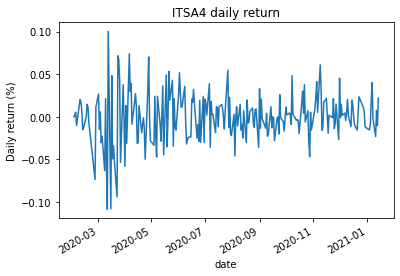

In [20]:
ax = itsa4_daily_return.plot()
ax.set_title("ITSA4 daily return")
_ = ax.set_ylabel("Daily return (%)")

This plot shows that the biggest and lowest daily returns in ITSA4 for train period happened in the beginning of COVID-19 quantine in Brazil (end of march/2020). In these days, price changed 10% in a single day.

#### CAPM

CAPM equations: $stockprice = \beta * marketprice + \alpha$

Beta is an indicator which decribes how a specific stock is correlated with the market.
Alpha is an offset between stockprice and market after beta variation, it usually is zero.

In [21]:
# Just picking up a arbitrary window=30 as example
capm_df = calculate_capm(itsa4, ibov, window=30)

beta = capm_df.loc[forecast_date].beta

In [22]:
print(f'Beta for data reference {forecast_date}, using 30 points to calculate line coefs is {round(beta, 2)}')

Beta for data reference 2020-12-01 00:00:00, using 30 points to calculate line coefs is 0.63


Beta is 0.63. Therefore, if ibovespa index (good proxy for brazilian market increases 100% tomorrow, ITSA4 will increases 63%).

#### Simple Moving Average (SMA)

SMA is mean average of adjclose price looking a window of days.

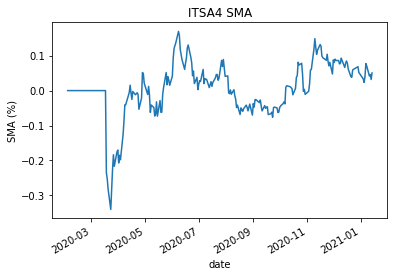

In [23]:
# Just picking up a arbitrary window=30 as example
ax = calculate_sma(itsa4, window=30).plot()
ax.set_title("ITSA4 SMA")
_ = ax.set_ylabel("SMA (%)")

How larger the window is, more smooth the series becomes. There are not all 30 point to calculate average in the oldest days, it is the reason this curve is flat in the beginning. However, aditional 180 days before `start_date` was included in this series to be cut after features creation. 

#### Exponential Moving Average (EMA)

EMA is similar to SMA, but recent dates have more weight than old dates in the window.

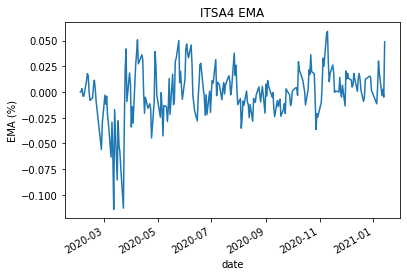

In [24]:
# Just picking up a arbitrary window=30 as example
ax = calculate_ema(itsa4, window=30).plot()
ax.set_title("ITSA4 EMA")
_ = ax.set_ylabel("EMA (%)")

Same consideration of SMA, but it gets faster variations in price due to greater weights in newest data.

#### Momentum

Momentum is the ratio of `forecast_price` and some day before. It gives a feeling of price's direction trend. 

In [25]:
# Just picking up a arbitrary window=7 as example
round(calculate_momentum(itsa4, window=7).loc[forecast_date], 2)

-0.04

In `forecast_date` momentum indicates almost no moving in prices.

#### Volatility

Volatility is the standard deviation in a window of days. In stock market, this is associated with risk. How more volatile the market is, greater the risk.

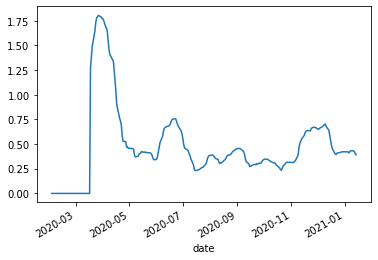

In [26]:
calculate_volatility(itsa4, window=30).plot()
ax.set_title("ITSA4 Volatility")
_ = ax.set_ylabel("Volatility")

In this plot is possible to observe market response with high oscilation due to beginning of Covid-19's quarantine in Brazil (end of march 2020).

#### Defining windows parameters

To create `vars_df` dataframe with calculated features were choosen some windows for each indicator based in practical knowledges:

- https://www.investopedia.com/terms/s/sma.asp
- https://www.investopedia.com/terms/e/ema.asp

Obs. consecutive days transformed to work days.

Other windows are created arbitrarily and some indicator were combined. 

Example of combined indicator: `sma_momentum_36` - it is SMA of momentum series with windows 36 work days before `forecast_date`.

Ticker (ITSA) feature is the last price that we have information for prediction, it was used as a feature too.

#### List of features:
- SMA stock price for last 7, 14, 36, 73 and 146 workdays
- Momentum stock price for last 36 workdays
- SMA Momentum for last 7, 36 and 73 workdays (momentum fixed in 36)
- SMA ^BVSP for last 73 workdays
- Volatility stock price for last 73 workdays
- Volatility ^BVSP for last 73 workdays
- Beta between stock price and ^BVSP for last 73 workdays
- EMA stock price for last 7, 14, 36, 73 and 146 workdays
- Last stock price

#### Target creation

For target creation, it was slid back n rows of `adjclose price` in ordered date time series according target option:
- `1_day` - slide 1 row
- `1_week` - slide 5 rows
- `2_weeks` - slide 10 rows
- `1_month` - slide 22 rows 

#### Final dataframe with features and targets

`prep_modeling_data` receives clean adjclose price from itsa4 and ibov and create all features that we need. If `target_flag` is True, it will create targets too.

In [27]:
# Encapsulate function to create features dataframe and drop aditional period apart from start and end date range
itsa4_vars_df = TrainModel.prep_modeling_data(itsa4, ibov, targets_dict, start_date, end_date, target_flag=True)

In [28]:
itsa4_vars_df.head()

,sma_ITSA4_7,sma_ITSA4_14,sma_ITSA4_36,sma_ITSA4_73,sma_ITSA4_146,sma_momentum_7,sma_momentum_36,sma_momentum_73,sma_^BVSP_73,volatility_^BVSP,...,ema_ITSA4_7,ema_ITSA4_14,ema_ITSA4_36,ema_ITSA4_73,ema_ITSA4_146,ITSA4,target_1_day,target_1_week,target_2_weeks,target_1_month
date,,,,,,,,,,,,,,,,,,,,,
2020-08-03,-0.011352,0.010251,0.046369,0.115538,0.0,0.121951,2.642979,-7.213103,0.123375,9262.239827,...,-0.008416,-0.006497,-0.006295,-0.006295,-0.006295,10.499140,10.018339,10.165523,9.449225,9.469027
2020-08-04,-0.053628,-0.035623,-0.003308,0.062541,0.0,-0.335315,0.981540,-5.031986,0.102074,9208.903455,...,-0.036086,-0.035267,-0.035141,-0.035141,-0.035141,10.018339,10.008525,10.008525,9.636048,9.666503
2020-08-05,-0.044177,-0.036892,-0.005471,0.059596,0.0,-0.303025,0.846613,-5.408202,0.115663,9200.616996,...,-0.023409,-0.024442,-0.024350,-0.024350,-0.024350,10.008525,10.126274,9.920216,9.567217,9.646756
2020-08-06,-0.025627,-0.025890,0.005168,0.069779,0.0,-0.175943,0.989120,-6.780680,0.125939,9185.385496,...,-0.006870,-0.008686,-0.008618,-0.008618,-0.008618,10.126274,10.018339,9.674907,9.508223,9.518396
2020-08-07,-0.023900,-0.034906,-0.005439,0.055634,0.0,-0.074646,0.975432,-8.300813,0.106841,9034.175204,...,-0.009878,-0.012895,-0.012872,-0.012872,-0.012872,10.018339,10.165523,9.743596,9.567217,9.557892


### Implementation

They are tested 3 types of models: Linear regression, random forest and neural net. Both using sklearn package. Standard scaler was used as default to normalize all features, but in random forest it does not have any effect. pipeline structure to keep it easy and organized.

#### Models

##### Linear Regression

Linear regression was used as a baseline to start improving the solution.

In [29]:
lr = LinearRegression()
pipeline_lr = make_pipeline(StandardScaler(), lr)

##### Random Forest

Random Forest was set up with few estimatores. It was tested manually parameters changed, and MAE does not decrease if is increased the number of estimators.

In [30]:
rf = RandomForestRegressor(random_state=0, n_estimators=1000)
pipeline_rf = make_pipeline(StandardScaler(), rf)

##### Neural Net

Neural net was used with a small architecture, some variations were tested manually. If it is increased network architecture, it starts to overfit. `early_stopping` was set to True to help avoid overfitting. It had a good performance in specific cases.

In [31]:
neural_net = MLPRegressor(hidden_layer_sizes=(50, 50), activation='tanh', solver='adam',
                           random_state=0, alpha=10, learning_rate='constant', max_iter=10**5,
                           shuffle=False, early_stopping=True)
pipeline_neuralnet = make_pipeline(StandardScaler(), neural_net)

In [32]:
# encapsulating pipelines for evaluation
pipelines = {'lr': pipeline_lr,
             'rf': pipeline_rf,
             'neural_net': pipeline_neuralnet}

### Refinement

The process of building new features were long and iterative. It was necessary to go back to theoretical concepts, review function implementations and evalute results a few times. There are a lot of python package for diverse uses. However, in this case due to window days context, it was necessary to code these functions.

For modeling step, the first approach was linear regression but it does not fit well in time series with a lot of oscillation. Therefore, it was tested random forest and neural net too. For setup random forest was pretty straightforward, but for artificial neural network was necessary iterate to find best params at least for an specific scenario.

## <a class="anchor" id="Results">Part 4 : Results</a>

### Model Evaluation and Validation

#### ITSA4

In [33]:
# Calculate MAE result of test set for ITSA4
itsa4_result = TrainModel.calculate_results(itsa4_vars_df, targets_dict, pipelines)
itsa4_result

target,1_day,1_week,2_weeks,1_month
lr,0.710812,2.96192,1.48595,1.79119
rf,0.735571,1.42158,1.2544,1.54622
neural_net,0.509756,1.22557,1.06636,0.706233


In [34]:
# Overall performance for ITSA4
itsa4_result.mean(axis=1)

lr            1.737468
rf            1.239441
neural_net    0.876977
dtype: float64

For ITSA4 both models were similar, neural net showed a better performance and linear regression a lower overall performance.

#### MGLU3

In [35]:
# Prep features for MGLU3
mglu3, ibov = TrainModel.prep_historical_data(stocks_df, 'MGLU3', start_date, end_date)
vars_mglu3_df = TrainModel.prep_modeling_data(mglu3, ibov, targets_dict, start_date, end_date, True)

In [36]:
# Calculate MAE result of test set for MGLU3
mglu3_result = TrainModel.calculate_results(vars_mglu3_df, targets_dict, pipelines)
mglu3_result

target,1_day,1_week,2_weeks,1_month
lr,25.2759,24.5517,24.3108,6.28074
rf,0.70692,1.20809,0.920421,0.615184
neural_net,1.93093,1.58102,1.60405,1.8777


In [37]:
# Overall performance for MGLU3
mglu3_result.mean(axis=1)

lr            20.104763
rf             0.862653
neural_net     1.748426
dtype: float64

For MGLU3, linear regression did not work well, and random forest were better than neural net.

#### EGIE3

In [38]:
# Prep features for EGIE3
egie3, ibov = TrainModel.prep_historical_data(stocks_df, 'EGIE3', start_date, end_date)
vars_egie3_df = TrainModel.prep_modeling_data(egie3, ibov, targets_dict, start_date, end_date, True)

In [39]:
# Calculate MAE result of test set for EGIE3
egie3_result = TrainModel.calculate_results(vars_egie3_df, targets_dict, pipelines)
egie3_result

target,1_day,1_week,2_weeks,1_month
lr,1.69305,10.1717,5.58798,6.81806
rf,1.06831,0.629994,0.935271,2.27706
neural_net,13.6179,13.6655,13.4215,14.3928


In [40]:
# Overall performance for EGIE3
egie3_result.mean(axis=1)

lr             6.067696
rf             1.227661
neural_net    13.774454
dtype: float64

For EGIE3, linear regression and neural net overfitted. Random forest sustained a good performance.

### Justification

Linear regression looks too simple for this type of problem, it had the worst performance in both cases. Patterns changes a lot over time in this context and it is not a robust solution.

Neural net had a really good performance for specific cases such as ITSA4. If it was tunned a specific 
network architecture for each stock, probably it would have a better performance. However, this point indicates neural nets perform well in restrict contexts. But for stock price prediction, in same data series can vary widely in their patterns over time. For this reason, no further investigation was done using neural networks.

Random forest performs well in both cases and it was choosen as the best model due to its robustness.

### Perceptions abount predicted curves shape

Looking for some insights, it will be analyzed visually the model performance using random forest.

In [41]:
# Prepare a test set period to plot curves
start_date_test = end_date + pd.DateOffset(days=1)
end_date_test = stocks_df.date.max() - pd.DateOffset(days=35)

In [42]:
print(f'In test set: \nstart_date is {start_date_test.strftime("%Y-%m-%d")}')
print(f'test_date is {end_date_test.strftime("%Y-%m-%d")}')

In test set: 
start_date is 2020-12-01
test_date is 2021-01-08


In [43]:
# Train model for all symbols and targets config params (Random Forest used)
train_model.create_models()

# Load pickle models
models = load_models(models_path)

####  Curves shape for ITSA4

In [44]:
# Create dataframe with features and targets in test period for ITSA4
itsa4_test, ibov_test = TrainModel.prep_historical_data(stocks_df, 'ITSA4', start_date_test, end_date_test)
vars_itsa4_test_df = TrainModel.prep_modeling_data(itsa4_test, ibov_test, targets_dict, start_date_test, end_date_test, True)

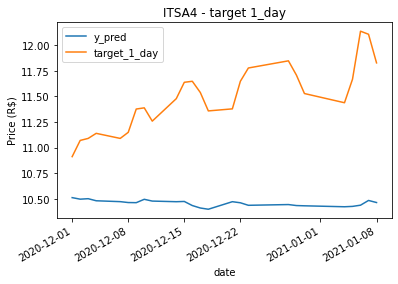

In [45]:
# Plot result for next day prediction
ax = TrainModel.plot_test_result('1_day', models, 'ITSA4', vars_itsa4_test_df)

This model only keeps price in a safe mean deslocated from real price. It does not try to predict oscilations.

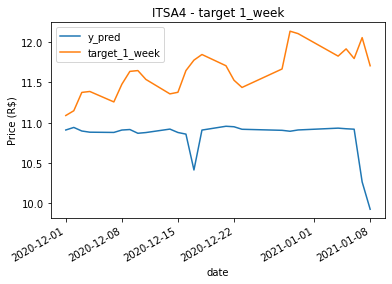

In [46]:
# Plot result for next week prediction
ax = TrainModel.plot_test_result('1_week', models, 'ITSA4', vars_itsa4_test_df)

This model keeps safe in a mean and forecast price decay tendency in last variation, but there is a error offset between the two curves.

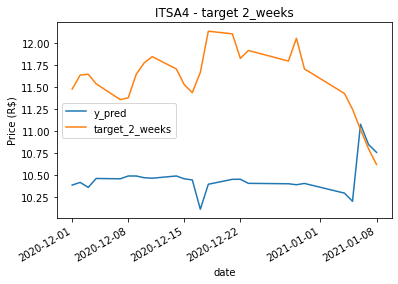

In [47]:
# Plot result for next 2 weeks prediction
ax = TrainModel.plot_test_result('2_weeks', models, 'ITSA4', vars_itsa4_test_df)

Same pattern of last plot, but a bit more smoothed and it fixs offset error in the end.

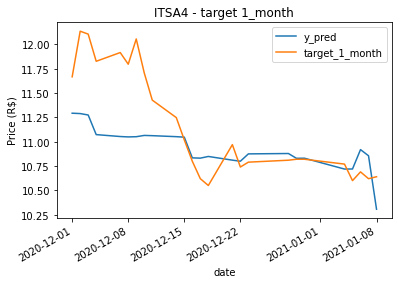

In [48]:
# Plot result for next month prediction
ax = TrainModel.plot_test_result('1_month', models, 'ITSA4', vars_itsa4_test_df)

This slow shows a good prediction after `2020-12-15`, bacause the area between the two curves is small.

####  Curves shape for MGLU3

In [49]:
mglu3_test, ibov_test = TrainModel.prep_historical_data(stocks_df, 'MGLU3', start_date_test, end_date_test)
vars_mglu3_test_df = TrainModel.prep_modeling_data(mglu3_test, ibov_test, targets_dict, start_date_test, end_date_test, True)

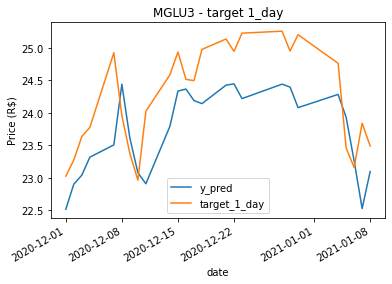

In [50]:
# Plot result for next day prediction
ax = TrainModel.plot_test_result('1_day', models, 'MGLU3', vars_mglu3_test_df)

This model is just copying past price behaviour.

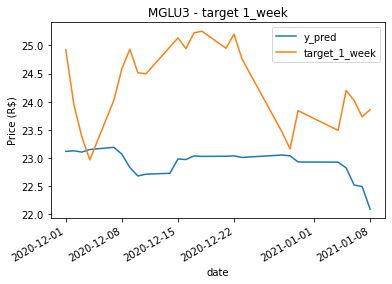

In [51]:
# Plot result for next week prediction
ax = TrainModel.plot_test_result('1_week', models, 'MGLU3', vars_mglu3_test_df)

This model keeps price prediction in a safe mean, and got a wrong direction in the end.

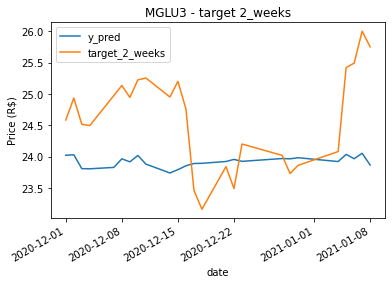

In [52]:
# Plot result for next 2 weeks prediction
ax = TrainModel.plot_test_result('2_weeks', models, 'MGLU3', vars_mglu3_test_df)

This plot shows a "safe mean" model too.

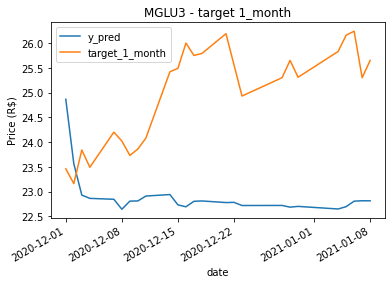

In [53]:
# Plot result for next month prediction
ax = TrainModel.plot_test_result('1_month', models, 'MGLU3', vars_mglu3_test_df)

It is a bit strange the first predictions, but it keeps price in a safe mean too.

####  Curves shape for EGIE3

In [54]:
egie3_test, ibov_test = TrainModel.prep_historical_data(stocks_df, 'EGIE3', start_date_test, end_date_test)
vars_egie3_test_df = TrainModel.prep_modeling_data(egie3_test, ibov_test, targets_dict, start_date_test, end_date_test, True)

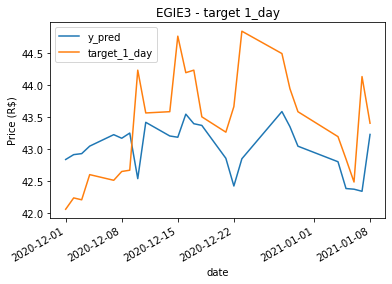

In [55]:
# Plot result for next day prediction
ax = TrainModel.plot_test_result('1_day', models, 'EGIE3', vars_egie3_test_df)

This model is only copying the past price behaviour.

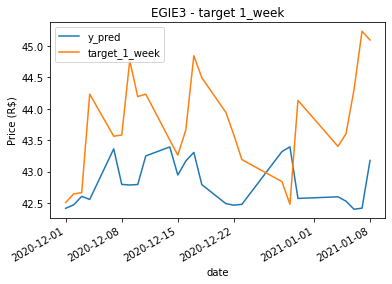

In [56]:
# Plot result for next week prediction
ax = TrainModel.plot_test_result('1_week', models, 'EGIE3', vars_egie3_test_df)

This model tries to make a real prediction. It is possible to see in the end of december, the model predicts the fall of prices but there is a offset error.

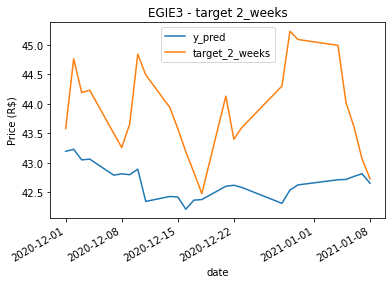

In [57]:
# Plot result for next 2 weeks prediction
ax = TrainModel.plot_test_result('2_weeks', models, 'EGIE3', vars_egie3_test_df)

This plot makes some good predictions in price direction, but it is too smoothed.

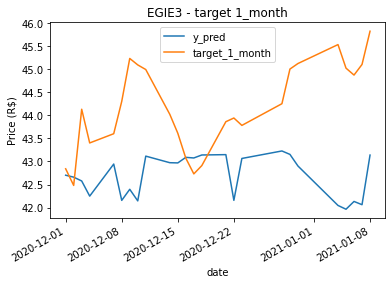

In [58]:
# Plot result for next month prediction
ax = TrainModel.plot_test_result('1_month', models, 'EGIE3', vars_egie3_test_df)

This model tries to predict tendencies, but it is not so accurate.

## <a class="anchor" id="Conclusion">Part 5 : Conclusion</a>

### Reflection

In this project was colected and cleaned data from API, created a lot of features and explored different models setups. It was put all together and made some stock price predictions. It is not easy to know what kind of features to use and how long set up a time window for theses features. The patterns in this problem change a lot, and it is easy to overfit in train dataset tendencies. 

In result perceptions was possible to observe 3 types of model behaviours:
- Only keep safe in a mean price to not get a big error
- Copy past behaviour but nothing is new
- Try to predict some trend, but probably get wrong.

The last model type is the most interesting, it needs to be improved but it is a good start.

### Improvement

Forecasting stock prices is a broad challenge, there are many other hypothesis to test in future works:
- Use other model metric instead of MAE to check if the model takes more choices
- Use new features based in Fundamental analysis and apply text mining in social media to try to catch market trends
- Test new types of models, specific to time series.
- There is a lot of offset error in predictions, focusing on this problem can have a good performance gain